 # gather data

In [85]:
import pandas as pd
deployments_not_on_deepdao = pd.read_pickle('deployments_not_on_deepdao.pkl')
deployments_not_on_deepdao.head()

,platform,platform_id,name,website,additional,votes_count,proposals_count,platform_id_source,deepdao_organization_id,id
0,realms,ynQy8iEbJiFuYA4Nom6j7AjV3E7mPYzz9JoMWBfsNMw,sol test,NaN,NaN,0,0,NaN,NaN,d07997f5-6ecd-53d5-9adb-d67e494e2a07
1,realms,2RQ9KQUJocKasNeNniAqwuDL3tPVsyxuPPtgjHgcKaYG,ckvt22w62754511zol5hax8y16,NaN,NaN,0,0,NaN,NaN,5bd17ba9-a2c5-5e4d-83f6-562cbebe3161
2,realms,BDKmQnKFJHaAtiFwwFpyzYWt4y7zHjCHkXXKhfgswymn,test 6666,NaN,NaN,0,0,NaN,NaN,15baea14-a757-51ac-a7f6-af98a75175b4
3,realms,7ageSmQoFTanbXNMgEYb45ap7bNCc4KL2dzyYDzakXTx,Panda Patrol DAO,NaN,NaN,0,0,NaN,NaN,7bf65b50-6c89-5477-ba10-1e3cf06848c1
4,realms,9dab9rwkk2uPn2SBKhWuH174VpZG5pD4Jci5zveoa7ug,Bitmon Treasury DAO,NaN,NaN,0,0,NaN,NaN,02c85106-2baf-555f-b440-b5ad2063653d


In [86]:
deployments_not_on_deepdao.shape

(21791, 10)

In [87]:
# filter out the deployments that dont have a name
deployments_not_on_deepdao = deployments_not_on_deepdao[deployments_not_on_deepdao['name'].notna()]
deployments_not_on_deepdao.shape

(18659, 10)

 ## only the non-deepdao orgs...

In [88]:
pre_merge_deployments_df_array = deployments_not_on_deepdao['id'].to_numpy()
pre_merge_deployments_df_array


array([UUID('d07997f5-6ecd-53d5-9adb-d67e494e2a07'),
       UUID('5bd17ba9-a2c5-5e4d-83f6-562cbebe3161'),
       UUID('15baea14-a757-51ac-a7f6-af98a75175b4'), ...,
       UUID('8d3a64b1-6cb5-5d79-be7d-c4a5eb82ccaa'),
       UUID('3c151eed-dd52-54d6-95a5-e3fa3caa35bc'),
       UUID('bc45ca4c-c840-55ac-92b4-527e5ec4ce73')], dtype=object)

In [89]:
# break into chunks of 500
pre_merge_deployments_df_chunks = [pre_merge_deployments_df_array[i:i + 500] for i in range(0, len(pre_merge_deployments_df_array), 500)]
len(pre_merge_deployments_df_chunks)

38

In [90]:
# make a dir chunks
import os
import itertools
import numpy as np
os.mkdir('deployment_pairs_chunks')
# generate the pairs for each chunk
for i, chunk in enumerate(pre_merge_deployments_df_chunks):
    print(i)
    pairs = np.array(list(itertools.combinations(chunk, 2)))
    print(pairs.shape)
    np.save(f'deployment_pairs_chunks/{i}.npy', pairs)


FileExistsError: [Errno 17] File exists: 'deployment_pairs_chunks'

In [ ]:
# load embedding lookup dict name_embeddings.json
import json
with open('name_embeddings.json') as f:
    name_embeddings = json.load(f)
len(name_embeddings)

18659

In [ ]:
# import cosine_similarity
from sklearn.metrics.pairwise import cosine_similarity
def calculate_similarity(id1, id2):
    try:
        embedding1 = name_embeddings[str(id1)]
        embedding2 = name_embeddings[str(id2)]
    except KeyError:
        print(f'KeyError: {id1}, {id2}')
        raise KeyError
    similarity = cosine_similarity([embedding1], [embedding2])[0][0]
    return similarity

In [99]:
# for each chunk, calculate the similarity
for i in range(len(pre_merge_deployments_df_chunks)):
    print(i)
    # if already calculated, skip
    if os.path.exists(f'deployment_pairs_chunks/{i}_similarities.npy'):
        print('already calculated', i)
        continue
    pairs = np.load(f'deployment_pairs_chunks/{i}.npy', allow_pickle=True)
    similarities = []
    for pair in pairs:
        similarity = calculate_similarity(pair[0], pair[1])
        similarities.append(similarity)
    np.save(f'deployment_pairs_chunks/{i}_similarities.npy', similarities)

0
already calculated 0
1
already calculated 1
2
already calculated 2
3
already calculated 3
4
already calculated 4
5
already calculated 5
6
already calculated 6
7
already calculated 7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37


In [100]:
# find the completed chunks
completed_chunks = []
for i in range(len(pre_merge_deployments_df_chunks)):
    if os.path.exists(f'deployment_pairs_chunks/{i}_similarities.npy'):
        completed_chunks.append(i)
completed_chunks

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37]

In [101]:
# for each one, make a df with the pairs and similarities
import numpy as np
import pandas as pd
dfs = []
for i in completed_chunks:
    print(i)
    pairs = np.load(f'deployment_pairs_chunks/{i}.npy', allow_pickle=True)
    print(pairs.shape)
    similarities = np.load(f'deployment_pairs_chunks/{i}_similarities.npy', allow_pickle=True)
    print(similarities.shape)
    # make df like id_1, id_2, similarity
    df = pd.DataFrame({'id_1': pairs[:, 0], 'id_2': pairs[:, 1], 'similarity': similarities})
    dfs.append(df)

# concat all the dfs
df = pd.concat(dfs)
df.shape

0
(124750, 2)
(124750,)
1
(124750, 2)
(124750,)
2
(124750, 2)
(124750,)
3
(124750, 2)
(124750,)
4
(124750, 2)
(124750,)
5
(124750, 2)
(124750,)
6
(124750, 2)
(124750,)
7
(124750, 2)
(124750,)
8
(124750, 2)
(124750,)
9
(124750, 2)
(124750,)
10
(124750, 2)
(124750,)
11
(124750, 2)
(124750,)
12
(124750, 2)
(124750,)
13
(124750, 2)
(124750,)
14
(124750, 2)
(124750,)
15
(124750, 2)
(124750,)
16
(124750, 2)
(124750,)
17
(124750, 2)
(124750,)
18
(124750, 2)
(124750,)
19
(124750, 2)
(124750,)
20
(124750, 2)
(124750,)
21
(124750, 2)
(124750,)
22
(124750, 2)
(124750,)
23
(124750, 2)
(124750,)
24
(124750, 2)
(124750,)
25
(124750, 2)
(124750,)
26
(124750, 2)
(124750,)
27
(124750, 2)
(124750,)
28
(124750, 2)
(124750,)
29
(124750, 2)
(124750,)
30
(124750, 2)
(124750,)
31
(124750, 2)
(124750,)
32
(124750, 2)
(124750,)
33
(124750, 2)
(124750,)
34
(124750, 2)
(124750,)
35
(124750, 2)
(124750,)
36
(124750, 2)
(124750,)
37
(12561, 2)
(12561,)


(4628311, 3)

In [102]:
id_p_pid_name = deployments_not_on_deepdao[['id', 'platform', 'platform_id', 'name']]
# join to the df on id_1 and suffix _1
df = df.merge(id_p_pid_name.add_suffix('_1'), on='id_1', validate='many_to_one')
df = df.merge(id_p_pid_name.add_suffix('_2'), on='id_2', validate='many_to_one')
df.sort_values('similarity', ascending=False).head(20)

,id_1,id_2,similarity,platform_1,platform_id_1,name_1,platform_2,platform_id_2,name_2
4519439,8b6047cc-393f-50c2-a402-6e5f2faaeabb,49934629-1328-5fa2-8d34-fab6e66d77c7,1.0,snapshot,xiaolototo.eth,xiaolototo,snapshot,xiaomimi.eth,xiaolototo
1441827,9e1f148f-463c-5151-8814-b269f8a17224,643b2e11-c49a-527d-a414-9908aec4de76,1.0,snapshot,galaxyllc.eth,伯,snapshot,803740.eth,气
3862794,3d69f7f1-adb6-5c2f-94a5-3d4b9cd3cb31,9024e3ea-9ad3-5d1b-baf6-3d98b63bf635,1.0,snapshot,hawaii.joints.eth,HAWAIIDAO,snapshot,hawaii.openuse.eth,HAWAIIDAO
577605,dc9237ba-0c07-5090-9ebb-5163c392b6ab,da6ddcae-208d-5d60-a46f-858f6779e074,1.0,tally,eip155:137:0x8b4aB08dF28579EC8363D1472cE2d3f9F...,Panda Ventures DAO,tally,eip155:137:0xaF5394c523F2BAf2a728BBFdb2FB385f6...,Panda Ventures DAO
2499850,f828b8ff-8638-5640-a62a-0b2b24adb68a,cbd85368-ca1a-5db4-a982-7a1f92dcdc0e,1.0,snapshot,b2b.ensmaxisfam.eth,B2BDAO,snapshot,b2b.joints.eth,B2BDAO
674127,e1672201-2f47-5fb5-bb16-81664dab3346,fa7ea0a6-3e40-5cc0-b391-aee938b4375f,1.0,daohaus,0x2c0b4b254832fb78ad5609871273d4e8c9eb8121,qwerqwer,daohaus,0xca8cb4bff49d172a9b46b5d3892d9a91daefd41c,qwerqwer
4499000,be17a577-d8b5-56c0-a5b9-e12b5e69c551,1770df22-5e1c-534e-a317-169402d21995,1.0,snapshot,domains.joints.eth,DOMAINSDAO,snapshot,domains.openuse.eth,DOMAINSDAO
635836,09bc6388-e96e-5276-bbde-0f3fe05a79f4,aead6cec-8835-5ad8-8f53-cb5abde89f83,1.0,tally,eip155:1:0x6CC90C97a940b8A3BAA3055c809Ed16d609...,Pony Finance,tally,eip155:1:0xC60a226bD2a90e4865331cfe81519EC13B4...,Pony Finance
4282000,f795019a-7b64-5fd3-a9d8-05fc07fa6248,0562e25a-2112-52f1-8177-f3ed60122a68,1.0,snapshot,free.ensmaxisfam.eth,freeDAO,snapshot,g699699.eth,freedao
4282001,2c40ceed-5c77-5d37-81ab-3763e9e965bf,0562e25a-2112-52f1-8177-f3ed60122a68,1.0,snapshot,free.joints.eth,FREEDAO,snapshot,g699699.eth,freedao


In [103]:
# save
df.to_pickle('deployment_pairs.pkl')

In [104]:
# remove platform_id_1 and platform_id_2
df = df.drop(['platform_id_1', 'platform_id_2'], axis=1)
df.sort_values('similarity', ascending=False).head(20)

,id_1,id_2,similarity,platform_1,name_1,platform_2,name_2
4519439,8b6047cc-393f-50c2-a402-6e5f2faaeabb,49934629-1328-5fa2-8d34-fab6e66d77c7,1.0,snapshot,xiaolototo,snapshot,xiaolototo
1441827,9e1f148f-463c-5151-8814-b269f8a17224,643b2e11-c49a-527d-a414-9908aec4de76,1.0,snapshot,伯,snapshot,气
3862794,3d69f7f1-adb6-5c2f-94a5-3d4b9cd3cb31,9024e3ea-9ad3-5d1b-baf6-3d98b63bf635,1.0,snapshot,HAWAIIDAO,snapshot,HAWAIIDAO
577605,dc9237ba-0c07-5090-9ebb-5163c392b6ab,da6ddcae-208d-5d60-a46f-858f6779e074,1.0,tally,Panda Ventures DAO,tally,Panda Ventures DAO
2499850,f828b8ff-8638-5640-a62a-0b2b24adb68a,cbd85368-ca1a-5db4-a982-7a1f92dcdc0e,1.0,snapshot,B2BDAO,snapshot,B2BDAO
674127,e1672201-2f47-5fb5-bb16-81664dab3346,fa7ea0a6-3e40-5cc0-b391-aee938b4375f,1.0,daohaus,qwerqwer,daohaus,qwerqwer
4499000,be17a577-d8b5-56c0-a5b9-e12b5e69c551,1770df22-5e1c-534e-a317-169402d21995,1.0,snapshot,DOMAINSDAO,snapshot,DOMAINSDAO
635836,09bc6388-e96e-5276-bbde-0f3fe05a79f4,aead6cec-8835-5ad8-8f53-cb5abde89f83,1.0,tally,Pony Finance,tally,Pony Finance
4282000,f795019a-7b64-5fd3-a9d8-05fc07fa6248,0562e25a-2112-52f1-8177-f3ed60122a68,1.0,snapshot,freeDAO,snapshot,freedao
4282001,2c40ceed-5c77-5d37-81ab-3763e9e965bf,0562e25a-2112-52f1-8177-f3ed60122a68,1.0,snapshot,FREEDAO,snapshot,freedao


In [106]:
# remove values that have the word test in name_1 or name_2
df_no_test = df[~df['name_1'].str.contains('test')]
df_no_test = df[~df['name_1'].str.contains('Test')]
df_no_test = df[~df['name_1'].str.contains('TEST')]
df_no_test = df_no_test[~df_no_test['name_2'].str.contains('test')]
df_no_test = df_no_test[~df_no_test['name_2'].str.contains('Test')]
df_no_test = df_no_test[~df_no_test['name_2'].str.contains('TEST')]
# show values where platforms are diff
df_no_test[df_no_test['platform_1'] != df_no_test['platform_2']].sort_values('similarity', ascending=False).head(20)

,id_1,id_2,similarity,platform_1,name_1,platform_2,name_2
698164,e7ce0f4e-cb02-5dab-8331-50794ccca3c7,6052f2c3-6e8a-5b9c-9a1e-0f60071609b9,1.000000,tally,测试,daohaus,测试
692897,272473f2-8801-5059-a435-a9698f5f99d8,2670621c-6620-538b-b5dc-d9e9ceda53e2,0.807146,tally,Content Guild,daohaus,Guild
735067,5175600c-4517-5112-9737-923ce20b2a35,df5b6406-47bb-5e80-b5a7-8255680109eb,0.800815,tally,CtrlX,daohaus,CTRL (Ethereum)
701257,1124463f-e4d7-53ba-8f96-fbd5daee2446,f2639e49-1e6a-53c3-b5d7-cc973c684611,0.779011,tally,CryptoFlx,daohaus,CryptoversePlaX
586181,7c7ff8e6-bc99-57bf-a82f-924014c04905,8a3400cc-e655-556f-8c3e-9d5454612f65,0.760892,realms,SuperHackaDAO,tally,SuperDao
512931,22139a42-76d7-56d4-b9c5-6a0cfcbcd9d7,1b9b74e8-c025-5d2f-af5f-d1b9846e67e5,0.748902,realms,Crypto Bastards DAO,tally,Crypto Ocean DAO
691911,377b2448-3cd8-5d4e-976f-2171ab3dd7c0,9b099011-1bbf-5726-b298-380e10833835,0.742922,daostack,DappHero DAO,daohaus,Fabrikapp DAO
514599,29d77ba4-bf67-5820-bde9-c55052bde2e3,6ec3da51-9ce1-5f4a-961b-3d75d4099103,0.739391,realms,Yolo Dao,tally,YAY DAO
694796,c1f1ad51-a893-574f-b652-747688a92512,a232147c-bb26-55ea-9cdd-bbcf9bb55de2,0.738799,tally,Signata DAO,daohaus,Saphira DAO
518213,129c25e6-9ce0-5d86-935d-e2fa0609fcaf,2cdce98a-d219-5e04-adb7-d7cc1170cc69,0.732140,realms,hype dao,tally,DAO NAME


<Axes: >

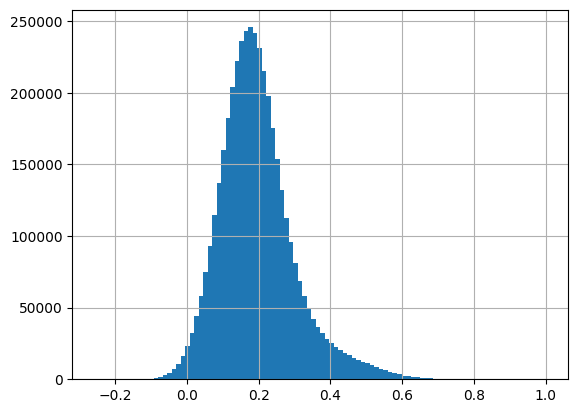

In [113]:
# similarity hist
df_no_test['similarity'].hist(bins=100)

In [122]:
# how many no test rows have similarity > 0.9
df_no_test[df_no_test['similarity'] > 0.85].shape

(664, 7)

There are 664 DAOs that have a similarity score of over 0.85 and don't contain the word test

In [127]:
df_no_test_gt_85 = df_no_test[df_no_test['similarity'] > 0.85]
# sort by similarity desc
df_no_test_gt_85 = df_no_test_gt_85.sort_values('similarity', ascending=False)
df_no_test_gt_85.head()

,id_1,id_2,similarity,platform_1,name_1,platform_2,name_2
4519439,8b6047cc-393f-50c2-a402-6e5f2faaeabb,49934629-1328-5fa2-8d34-fab6e66d77c7,1.0,snapshot,xiaolototo,snapshot,xiaolototo
577605,dc9237ba-0c07-5090-9ebb-5163c392b6ab,da6ddcae-208d-5d60-a46f-858f6779e074,1.0,tally,Panda Ventures DAO,tally,Panda Ventures DAO
1441827,9e1f148f-463c-5151-8814-b269f8a17224,643b2e11-c49a-527d-a414-9908aec4de76,1.0,snapshot,伯,snapshot,气
3862794,3d69f7f1-adb6-5c2f-94a5-3d4b9cd3cb31,9024e3ea-9ad3-5d1b-baf6-3d98b63bf635,1.0,snapshot,HAWAIIDAO,snapshot,HAWAIIDAO
4282001,2c40ceed-5c77-5d37-81ab-3763e9e965bf,0562e25a-2112-52f1-8177-f3ed60122a68,1.0,snapshot,FREEDAO,snapshot,freedao


In [129]:
# save to excel for manual review
df_no_test_gt_85.to_excel('similarity_pairs_to_be_manually_reviewed.xlsx')

strategy

* for similarity = 1, assume a match unless name is generic, i.e., "DAO"
* ignored non-english titles unless they were an exact match
* did not match plural/non-plurals, i.e., computerDAO and computersDAO, AirDrop Birds DAO and AirDrop Bird DAO
* did match the same name w diff numbering, i.e., bResolute 0.1 and bResolute 0.3
* did match The Accrew DAO and Accrew DAO
* did match numbers in series qq3332 and qq333
* did match laopao.eth and laopao

In [131]:
# load in manual review
df_manual_review = pd.read_excel('similarity_pairs_manually_reviewed.xlsx')
df_manual_review.head()

,Unnamed: 0,id_1,id_2,similarity,platform_1,platform_2,name_1,name_2,result
0,4519439,8b6047cc-393f-50c2-a402-6e5f2faaeabb,49934629-1328-5fa2-8d34-fab6e66d77c7,1.0,snapshot,snapshot,xiaolototo,xiaolototo,True
1,577605,dc9237ba-0c07-5090-9ebb-5163c392b6ab,da6ddcae-208d-5d60-a46f-858f6779e074,1.0,tally,tally,Panda Ventures DAO,Panda Ventures DAO,True
2,1441827,9e1f148f-463c-5151-8814-b269f8a17224,643b2e11-c49a-527d-a414-9908aec4de76,1.0,snapshot,snapshot,伯,气,False
3,3862794,3d69f7f1-adb6-5c2f-94a5-3d4b9cd3cb31,9024e3ea-9ad3-5d1b-baf6-3d98b63bf635,1.0,snapshot,snapshot,HAWAIIDAO,HAWAIIDAO,True
4,4282001,2c40ceed-5c77-5d37-81ab-3763e9e965bf,0562e25a-2112-52f1-8177-f3ed60122a68,1.0,snapshot,snapshot,FREEDAO,freedao,False


In [132]:
# filter result = True
df_manual_review = df_manual_review[df_manual_review['result'] == True]
df_manual_review.shape

(325, 9)

In [133]:
# adding 325 groups
# keep only id_1, id_2, result
df_manual_review = df_manual_review[['id_1', 'id_2', 'result']]
df_manual_review.head()

,id_1,id_2,result
0,8b6047cc-393f-50c2-a402-6e5f2faaeabb,49934629-1328-5fa2-8d34-fab6e66d77c7,True
1,dc9237ba-0c07-5090-9ebb-5163c392b6ab,da6ddcae-208d-5d60-a46f-858f6779e074,True
3,3d69f7f1-adb6-5c2f-94a5-3d4b9cd3cb31,9024e3ea-9ad3-5d1b-baf6-3d98b63bf635,True
6,f828b8ff-8638-5640-a62a-0b2b24adb68a,cbd85368-ca1a-5db4-a982-7a1f92dcdc0e,True
7,09bc6388-e96e-5276-bbde-0f3fe05a79f4,aead6cec-8835-5ad8-8f53-cb5abde89f83,True


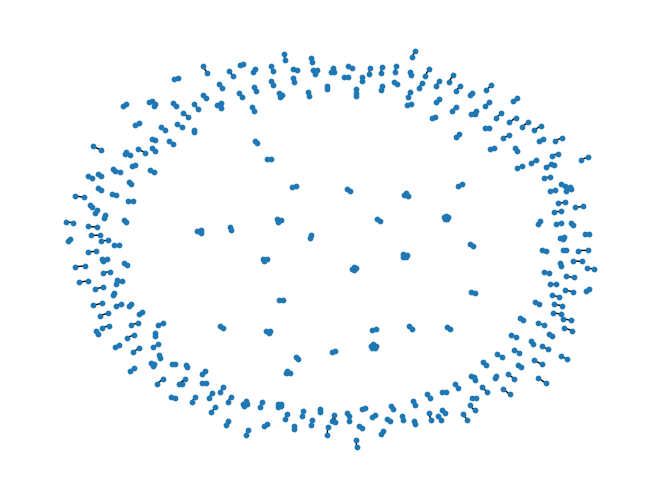

In [139]:
# make a networkx graph
import networkx as nx
G = nx.Graph()
# add nodes
G.add_nodes_from(df_manual_review['id_1'].values)
G.add_nodes_from(df_manual_review['id_2'].values)
# add edges
for i, row in df_manual_review.iterrows():
    G.add_edge(row['id_1'], row['id_2'])

# make the dots smaller
nx.draw(G, with_labels=False, node_size=10)
# these are all of the groups that we are adding

In [144]:
# get all of the groups
groups = list(nx.connected_components(G))
# what are the sizes of the groups
group_sizes = [len(group) for group in groups]
# average
np.mean(group_sizes)

2.1504065040650406

In [164]:
# concat id_1 and id_2 into a single list
ids = df_manual_review['id_1'].tolist() + df_manual_review['id_2'].tolist()
# make unique
ids = list(set(ids))
# make df
group_info_df = pd.DataFrame({'internal_deployment_id': ids, 'group_id': None})
group_info_df.head()

,internal_deployment_id,group_id
0,c82f6f82-9367-5f2a-aade-d4ba1d76af5c,None
1,af0dbef6-de41-5ce3-8f41-47762d8e3392,None
2,8201beae-4652-55e3-9ac2-bd01fa231a9f,None
3,90019a7f-0e73-57e7-88a1-ba56f38f0200,None
4,b6500d63-91f0-5023-ab77-5c1eda6b6977,None


In [165]:
# make a dict of group_id: [list of group element ids], generating a uuid for each group
import uuid
group_id_dict = {}
for i, group in enumerate(groups):
    group_id = str(uuid.uuid4())
    group_id_dict[group_id] = list(group)
group_id_dict

{'e03c910f-5264-4f36-a243-e3a2af6c8215': ['8b6047cc-393f-50c2-a402-6e5f2faaeabb',
  '49934629-1328-5fa2-8d34-fab6e66d77c7'],
 'a5715526-2efc-49d6-b1d4-01e0f736dc7f': ['dc9237ba-0c07-5090-9ebb-5163c392b6ab',
  'da6ddcae-208d-5d60-a46f-858f6779e074'],
 'a6bd4a4b-00d6-4d39-9892-175af3152b29': ['9024e3ea-9ad3-5d1b-baf6-3d98b63bf635',
  '3d69f7f1-adb6-5c2f-94a5-3d4b9cd3cb31'],
 '283fdc9f-3c18-41cc-a55e-822dd6f9d78c': ['f828b8ff-8638-5640-a62a-0b2b24adb68a',
  'cbd85368-ca1a-5db4-a982-7a1f92dcdc0e'],
 'e013cc4f-86e7-4216-a8f1-66c348a07a38': ['09bc6388-e96e-5276-bbde-0f3fe05a79f4',
  'aead6cec-8835-5ad8-8f53-cb5abde89f83'],
 '6a1a29cf-55a7-4a94-b562-f67626b5c4b4': ['fa7ea0a6-3e40-5cc0-b391-aee938b4375f',
  'e1672201-2f47-5fb5-bb16-81664dab3346'],
 '5cc1d367-20ea-4070-85b7-467a128867e8': ['cb99166a-d227-5341-b1ac-8166066ab476',
  '1167e000-8569-54dd-8d73-1a0a6c1cc89c'],
 '09cffc49-d274-4b98-8875-6b5515385a7a': ['63c135d2-1370-5868-a804-ca59c3a7c242',
  'fa949c2d-f61f-50e2-a601-71e636d436f5'],


In [166]:
len(group_id_dict)

246

In [167]:
# set the group_id for each group element in group_info_df
for group_id, group in group_id_dict.items():
    group_info_df.loc[group_info_df['internal_deployment_id'].isin(group), 'group_id'] = group_id
group_info_df.head()

,internal_deployment_id,group_id
0,c82f6f82-9367-5f2a-aade-d4ba1d76af5c,df269659-e28c-4eb0-8a48-9323d867c027
1,af0dbef6-de41-5ce3-8f41-47762d8e3392,f418ebde-3f84-4230-b640-8c7c56388c87
2,8201beae-4652-55e3-9ac2-bd01fa231a9f,d32480fc-2337-4bc4-824a-d4184a4391c0
3,90019a7f-0e73-57e7-88a1-ba56f38f0200,5907fbc9-887a-4eee-b00e-cd182d83de2a
4,b6500d63-91f0-5023-ab77-5c1eda6b6977,201805a6-2f28-4c70-8ee7-3587d5f6b8d9


In [168]:
# are the internal_deployment_ids unique?
group_info_df['internal_deployment_id'].value_counts().head()

c82f6f82-9367-5f2a-aade-d4ba1d76af5c    1
81dca2d9-a473-5568-a5d6-b215edce2042    1
3d7e1b31-83d7-513e-8f57-05ceda95d108    1
45c808e3-886d-5206-b029-fba4d9ea8785    1
8a48ae08-9f63-55c3-91f4-835c99f7d20a    1
Name: internal_deployment_id, dtype: int64

In [179]:
# count nans
group_info_df['group_id'].isna().sum()

0

In [180]:
# intersection bt group_info_df['group_id'] and deployments_not_on_deepdao['id']
group_info_df['internal_deployment_id'].isin(deployments_not_on_deepdao['id']).sum()
# shit :/

0

In [172]:
deployments_not_on_deepdao_with_groups = deployments_not_on_deepdao.merge(group_info_df, left_on='id', right_on='internal_deployment_id', how='left', validate='one_to_one')
deployments_not_on_deepdao_with_groups.head()

,platform,platform_id,name,website,additional,votes_count,proposals_count,platform_id_source,deepdao_organization_id,id,internal_deployment_id,group_id
0,realms,ynQy8iEbJiFuYA4Nom6j7AjV3E7mPYzz9JoMWBfsNMw,sol test,NaN,NaN,0,0,NaN,NaN,d07997f5-6ecd-53d5-9adb-d67e494e2a07,NaN,NaN
1,realms,2RQ9KQUJocKasNeNniAqwuDL3tPVsyxuPPtgjHgcKaYG,ckvt22w62754511zol5hax8y16,NaN,NaN,0,0,NaN,NaN,5bd17ba9-a2c5-5e4d-83f6-562cbebe3161,NaN,NaN
2,realms,BDKmQnKFJHaAtiFwwFpyzYWt4y7zHjCHkXXKhfgswymn,test 6666,NaN,NaN,0,0,NaN,NaN,15baea14-a757-51ac-a7f6-af98a75175b4,NaN,NaN
3,realms,7ageSmQoFTanbXNMgEYb45ap7bNCc4KL2dzyYDzakXTx,Panda Patrol DAO,NaN,NaN,0,0,NaN,NaN,7bf65b50-6c89-5477-ba10-1e3cf06848c1,NaN,NaN
4,realms,9dab9rwkk2uPn2SBKhWuH174VpZG5pD4Jci5zveoa7ug,Bitmon Treasury DAO,NaN,NaN,0,0,NaN,NaN,02c85106-2baf-555f-b440-b5ad2063653d,NaN,NaN


In [174]:
deployments_not_on_deepdao_with_groups.group_id.notna().sum()

0

In [171]:
# keep only rows with group_id and internal_deployment_id not null
deployments_not_on_deepdao_with_groups = deployments_not_on_deepdao_with_groups[~deployments_not_on_deepdao_with_groups['group_id'].isna()]
deployments_not_on_deepdao_with_groups.shape

(0, 12)